# Tutorial

## Cell genotyping

Import the sctools module, and import pandas to read the data.

In [1]:
import sctools

In [2]:
from sctools import genotype

In [3]:
import pandas as pd

In [4]:
sctools.__version__

u'0.6+21.g8f73878'

In [8]:
%matplotlib inline

### Part 1: detection of major clusters only

#### Data loading

We load in a file with SNP UMI counts for each cell barcode. This can be generated using `sctools countsnps`.

In [5]:
dat = pd.read_table("../tests/snp_counts.tsv.gz")

In [6]:
dat.head()

,cell_barcode,reference_count,alternate_count
0,ATTGGTGGTCATCGGC-1,0,1
1,GTGGGTCAGACAAAGG-1,11,16
2,GCTTCCACAGGGCATA-1,0,1
3,AAAGATGCAGTGGAGT-1,15,14
4,CACAGGCAGTGAACAT-1,76,7444


#### Pre-processing

First initiate the Genotype object using the SNP data

In [10]:
geno = genotype.Genotype(dat)

Now we need to remove cells with very low SNP UMI counts. This makes the following clustering steps easier as it removes the bulk of the empty droplets.

In [11]:
geno.filter_low_count()

In [12]:
geno.filtered_cells.shape, geno.snp_counts.shape

((53402, 3), (304489, 3))

In [13]:
geno.filtered_cells.head()

,cell_barcode,reference_count,alternate_count
1,GTGGGTCAGACAAAGG-1,11,16
3,AAAGATGCAGTGGAGT-1,15,14
4,CACAGGCAGTGAACAT-1,76,7444
13,GTACTTTCACAGACTT-1,13,23
19,GTCATTTCAGAAGCAC-1,13,19


Now we transform the SNP counts to be on a log scale

In [14]:
geno.transform_snps()

If we look at the data held by the `geno` object we can see the counts are now on a log scale

In [15]:
geno.log_snps.head()

,reference_count,alternate_count,cell_barcode
1,1.079181,1.230449,GTGGGTCAGACAAAGG-1
3,1.204120,1.176091,AAAGATGCAGTGGAGT-1
4,1.886491,3.871865,CACAGGCAGTGAACAT-1
13,1.146128,1.380211,GTACTTTCACAGACTT-1
19,1.146128,1.301030,GTCATTTCAGAAGCAC-1


We also have a `plot` method that can be called at any time to view the cells

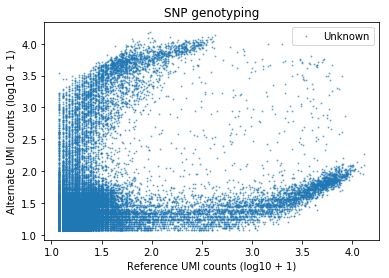

In [16]:
geno.plot()

#### Detection of clusters

Next we detect the background cells. We can adjust the parameters `eps` and `min_samples` here to adjust the sensitivity of background cell detection. `eps` is the epsilon parameter in DBSCAN clustering, and adjusts the local radius used for expanding clusters. The higher the `eps` value, the larger each cluster will be.

In [17]:
geno.detect_total_background()

Now that we have identified background empty droplets, we can now detect the real cells. Optionally, we can first check if there are similar numbers of cells in each genotype, and downsample more common genotypes to match the frequency of the less commmon genotype. This is useful when there is a large difference in the number of cells of each genotype, as density-based clustering using DBSCAN is sensitive to different cluster densities.

The `segment_cells` method checks if the cells should be downsampled to even out the density distribution, and returns a dataframe containing the downsampled data if downsampling is necessary. We can store this dataframe in the `.downsample_data` slot.

In [18]:
geno.downsample_data = geno.segment_cells()

To check if the cells were downsampled to adjust the densities, we can check if `geno.downsample_data` has been assigned:

In [19]:
geno.downsample_data is None

True

In this case the genotypes were evenly distributed and did not need to be downsampled.

Now we can detect the cell clusters.

In [20]:
geno.detect_cells()

#### Plotting

We can easily look at the results by plotting the SNP counts coloured by genotype.

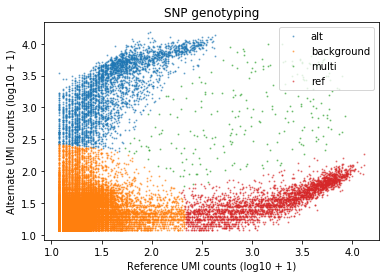

In [21]:
geno.plot()

We can also use a linear scale:

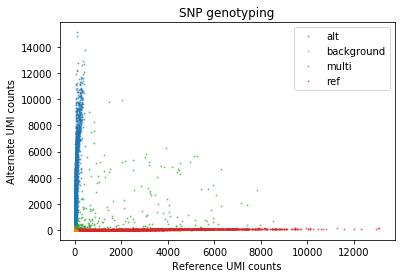

In [22]:
geno.plot(log_scale=False)

#### Summarize results

We can produce a summary of the genotyping results. Here the estimated multiplet number and percentage is adjusted according to the ratio of each genotype (multiplet cells will be less frequent if the proportion of one genotype to the other is very unbalanced)

In [23]:
geno.summarize()

,Count,Percentage
Reference,2850.000000,0.432868
Alternate,3490.000000,0.530073
Observed Multiplet,244.000000,0.037060
Estimated Multiplet,542.792982,0.082441


#### Saving results

The genotype information is stored in a pandas dataframe in `geno.labels`, and can be saved using the pandas function `to_csv`.

In [24]:
geno.labels.to_csv("../tests/genotypes.tsv.gz", sep="\t", index=False, compression='gzip')

For convenience, all the above steps can be run as a single function in the `genotype` module that returns a `Genotype` object.

In [25]:
gt = genotype.run_genotyping(dat)

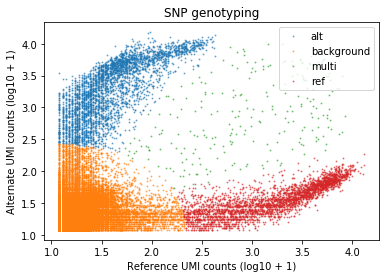

In [26]:
gt.plot()

### Part 2: detection of droplets at the boundary of background and cell

sctools provides some additional functions that allow cells on the border of background and real cell clusters to be identified. This may be useful for downstream analysis steps.

We begin this analysis similarly to as described above, by loading the SNP counts, transforming them, and removing low-count cells:

#### Data loading

In [27]:
dat = pd.read_table("../tests/snp_counts.tsv.gz")
boundary_cells = genotype.Genotype(dat)
boundary_cells.filter_low_count()
boundary_cells.transform_snps()

#### Detection of clusters

Next, we detect the core background cells that we have high confidence are background empty droplets

In [28]:
boundary_cells.detect_core_background()

Next detect the larger group of background cells

In [29]:
boundary_cells.detect_total_background()

Now that we have identified two clusters of background droplets (one the smaller, core group), we can detect the cells

In [30]:
boundary_cells.detect_cells()

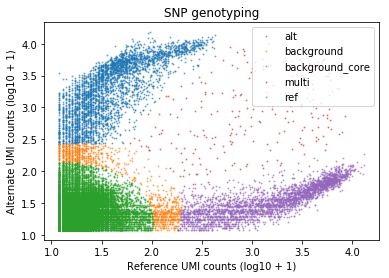

In [31]:
boundary_cells.plot()

Now that we have the group of droplets that are background, and the group of real cells, we next determine which cells are on the margin between background and real cells

In [32]:
boundary_cells.detect_margin_cells()

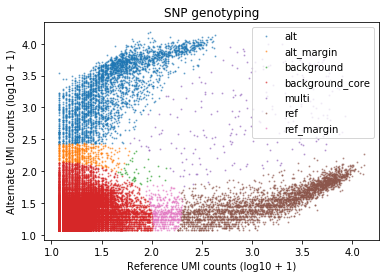

In [33]:
boundary_cells.plot()

As before, we can summarize these results. This summary counts the marginal cells as background.

In [34]:
boundary_cells.summarize()

,Count,Percentage
Reference,2911.00000,0.441797
Alternate,3441.00000,0.522234
Observed Multiplet,237.00000,0.035969
Estimated Multiplet,517.15012,0.078487


## Loading transcriptome data

The gene UMI count information for a scRNA-seq experiment is typically stored in [matrix market](http://math.nist.gov/MatrixMarket/formats.html#MMformat) format. To read this data as a sparse matrix, we use the `scipy.io.mmread` function in the scipy package.

sctools contains a class `SC` that is a convenient wrapper around the `mmread` function for reading the data matrix produced by the 10x Genomics CellRanger pipeline. This also contains a `subset` method, that allows the matrix to be subset according to gene names and cell barcodes. This was implemented as the standard scipy sparse matrix does not allow indexing by named columns or rows. To get around this, the `SC` object stores the cell barcodes and column indices, and the gene names and row indices, and uses this data behind the scenes to select the correct rows and columns.

*Note: for the purposes of this example, a much smaller test dataset is used that removes many cells and genes*

In [1]:
from sctools import sctools

In [2]:
matrix = sctools.SC()

In [3]:
matrix.read_10x("../tests/counts")

In [4]:
matrix.counts[0:5,0:5].toarray()

array([[2, 0, 2, 1, 8],
       [0, 0, 5, 3, 2],
       [0, 0, 0, 0, 0],
       [2, 0, 0, 1, 1],
       [0, 0, 0, 0, 0]])

### Subsetting cells

The matrix can be subset using a list of gene names and cell barcodes

In [5]:
wanted_cells = 'AAAGATGAGGTAGCTG AAAGATGCAATGTTGC AAAGATGCACCGCTAG AAAGATGCAGACGCTC AAAGATGCATCCCATC'.split()

In [6]:
filtered_matrix = matrix.subset(cells = wanted_cells)

The `subset` method returns another `SC` object.

In [7]:
filtered_matrix

<sctools.sctools.SC instance at 0x1092d1758>

### Viewing the counts

We also have a `head` method that prints the first few rows and columns as a nice dataframe

In [9]:
matrix.head(5)

,AAACCTGAGCTTTGGT,AAACCTGAGTGTACTC,AAACCTGCAATCGGTT,AAACCTGCATGACGGA,AAACCTGGTAGCTAAA
NAC001,2,0,2,1,8
ARV1,0,0,5,3,2
NGA3,0,0,0,0,0
DCL1,2,0,0,1,1
MIR838A,0,0,0,0,0


In [10]:
filtered_matrix.head(5)

,AAAGATGAGGTAGCTG,AAAGATGCAATGTTGC,AAAGATGCACCGCTAG,AAAGATGCAGACGCTC,AAAGATGCATCCCATC
NAC001,0,0,0,0,0
ARV1,2,0,2,0,2
NGA3,0,0,0,0,0
DCL1,0,0,0,0,0
MIR838A,0,0,0,0,0


### Counting UMIs

The total UMI counts per cell or per gene can be computed using the `count_umi` method

In [14]:
matrix.count_umi(axis=1).head()

,count
NAC001,130
ARV1,126
NGA3,18
DCL1,35
MIR838A,0


In [15]:
matrix.count_umi(axis=2).head()

,count
AAACCTGAGCTTTGGT,143
AAACCTGAGTGTACTC,115
AAACCTGCAATCGGTT,181
AAACCTGCATGACGGA,114
AAACCTGGTAGCTAAA,232
